In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


from CUB.utils import get_cub_attributes
from CUB.dataset import ImageTransformer

from captum.attr import IntegratedGradients, Saliency

/Users/melih/Documents/uni/sm3/mmai-projec-lab/ConceptBottleneckEval/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cub_attributes_list = get_cub_attributes()

In [3]:
certainties = {
    1: "not visible",
    2: "guessing",
    3: "probably",
    4: "definitely",
}

data_path = "./data/CUB_200_2011/"

image_attributes_file = data_path + "attributes/image_attribute_labels.txt"
attributes_names = data_path + "attributes/attributes.txt"

attributes_names_df = pd.read_csv(
    attributes_names,
    sep=" ",
    header=None,
    names=["attribute_id", "attribute_name"],
)
attributes_names = attributes_names_df.set_index("attribute_id")["attribute_name"].to_dict()

# <image_id> <attribute_id> <is_present> <certainty_id> <time>
image_attributes = pd.read_csv(
    image_attributes_file,
    sep=" ",
    header=None,
    names=[
        "image_id",
        "attribute_id",
        "is_present",
        "certainty_id",
        "time",
    ],
)

# select only the attributes that are in cub_attributes_list
image_attributes_cub = image_attributes[
    image_attributes["attribute_id"].isin(cub_attributes_list)
]


image_adresses = pd.read_csv(
    data_path + "images.txt",
    sep=" ",
    header=None,
    names=["image_id", "image_path"],
)


image_attributes_cub.tail()

image_id  attribute_id  is_present  certainty_id   time
3677848     11788           305           0             4  4.989
3677851     11788           308           1             4  4.989
3677852     11788           309           0             4  8.309
3677853     11788           310           0             4  8.309
3677854     11788           311           0             4  8.309

In [4]:
def random_sample():
    random_image_id = np.random.choice(
        image_attributes_cub["image_id"].unique()
    )

    random_image_attributes = image_attributes_cub[image_attributes_cub["image_id"] == random_image_id]
    present_attributes = random_image_attributes[random_image_attributes["is_present"] == 1]

    visible_attr = present_attributes.attribute_id.map(attributes_names).to_list()
    visible_attr_indx = present_attributes.attribute_id.to_list()

    image_path = image_adresses[image_adresses["image_id"] == random_image_id]["image_path"].values[0]
    image_path = data_path + "images/" + image_path

    image = Image.open(image_path)

    transformer = ImageTransformer(is_training=False)
    image_tensor = transformer(image).unsqueeze(0)  # Add batch dimension   

    return image_tensor, visible_attr, visible_attr_indx


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


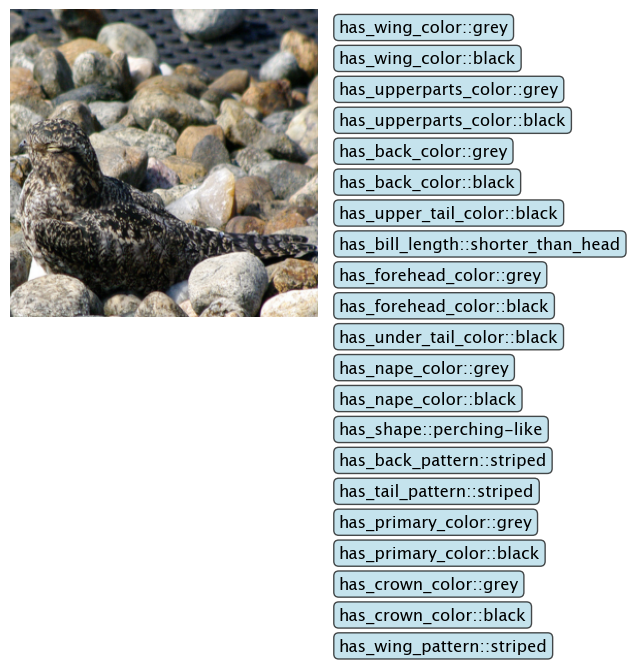

In [5]:
im_tensor, visible_attr, visible_attr_indx = random_sample()
image = torch.einsum("bchw->bhwc", im_tensor).squeeze(0).numpy()
# denormalize imagenet im
plot_im = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(plot_im)

# Add visible attributes as text to the right of the image
image_width = plot_im.shape[0]
y_start = 10
y_spacing = 30

for i, attr in enumerate(visible_attr):
    ax.text(image_width + 20, y_start + i * y_spacing, attr, 
            fontsize=12, verticalalignment='top', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

# Adjust plot limits to show the text
ax.set_xlim(0, image_width + 300)
ax.set_ylim(plot_im.shape[1], 0)  # Invert y-axis to match image coordinates
ax.axis('off')  # Remove axes

plt.tight_layout()
plt.show()

In [6]:
model = torch.load("CUB/pretrained/best_model_3.pth", map_location="cpu", weights_only=False)
model

/Users/melih/Documents/uni/sm3/mmai-projec-lab/ConceptBottleneckEval/.venv/lib/python3.12/site-packages/torch/serialization.py:1639: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/melih/Documents/uni/sm3/mmai-projec-lab/ConceptBottleneckEval/.venv/lib/python3.12/site-packages/torch/serialization.py:1639: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/melih/Documents/uni/sm3/mmai-projec-lab/ConceptBottleneckEval/.venv/lib/python3.12/site-packages/torch/serial

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [ ]:
im_tensor, visible_attr, visible_attr_indx = random_sample()

# Ensure model is in eval mode if doing inference
model.eval()

# Run with gradient context if needed
with torch.enable_grad():
    output = model(im_tensor)
    attr_outputs = [torch.nn.Sigmoid()(o) for o in output]


In [18]:

import torch.nn as nn

class TensorOutputWrapper(nn.Module):
    """
    Wrap a model that returns a list into one that returns a tensor.
    You can choose which element (or combine them) for attribution.
    """
    def __init__(self, model, out_index=0):
        super().__init__()
        self.model = model
        self.out_index = out_index

    def forward(self, x):
        out = self.model(x)
        # If model returns a list, select one element or concatenate them
        if isinstance(out, (list, tuple)):
            out = out[self.out_index]
        # Now ensure it's a tensor
        assert isinstance(out, torch.Tensor), "Selected output must be a tensor"
        return out

In [19]:
def aggregate_attributions(attrib_tensor, method="absolute_mean"):
    """
    Reduce channel dimension to single 2D map for visualization.
    attrib_tensor: (B, C, H, W)
    method: "absolute_mean" (default) or "mean" or "max"
    returns: (B, H, W) numpy arrays
    """
    a = attrib_tensor.detach().cpu().numpy()
    if method == "absolute_mean":
        return np.mean(np.abs(a), axis=1)
    elif method == "mean":
        return np.mean(a, axis=1)
    elif method == "max":
        return np.max(a, axis=1)
    else:
        raise ValueError("Unknown method")

In [20]:
def normalize_map(attrib_map):
    """
    Normalize an attribution map (H,W) or (B,H,W) to [0,1] for visualization.
    """
    m = attrib_map.copy()
    if m.ndim == 2:
        m = (m - m.min()) / (m.max() - m.min() + 1e-9)
    else:
        # batch
        for i in range(m.shape[0]):
            mm = m[i]
            m[i] = (mm - mm.min()) / (mm.max() - mm.min() + 1e-9)
    return m

In [21]:

def overlay_on_image(original_img, heatmap, alpha=0.5, cmap='jet'):
    """
    original_img: np array HxW x 3 in [0,1] or [0,255]
    heatmap: HxW normalized [0,1]
    returns: overlay rgb np array
    """
    if original_img.max() > 1.0:
        orig = original_img.astype(np.float32) / 255.0
    else:
        orig = original_img.copy()

    cmap_fn = plt.get_cmap(cmap)
    heat_rgba = cmap_fn(heatmap)

    heat_rgb = heat_rgba[..., :3]
    overlay = (1 - alpha) * orig + alpha * heat_rgb
    overlay = np.clip(overlay, 0, 1)
    
    return overlay

/var/folders/0s/djcnggfx34j59ddzgqd699z80000gn/T/ipykernel_2044/2306752232.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_np = np.array(im_tensor.detach().cpu()[0].permute(1, 2, 0))


/var/folders/0s/djcnggfx34j59ddzgqd699z80000gn/T/ipykernel_2044/2426832055.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_np = np.array(im_tensor.detach().cpu()[0].permute(1, 2, 0))


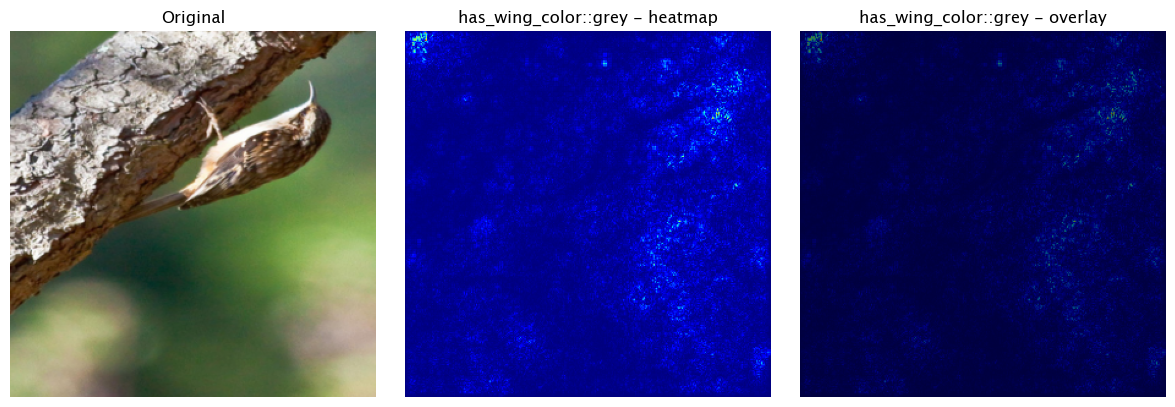

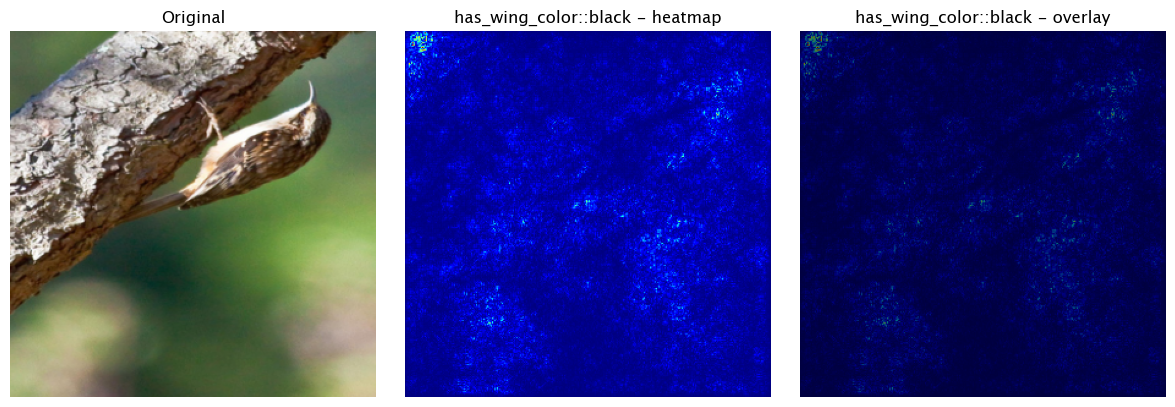

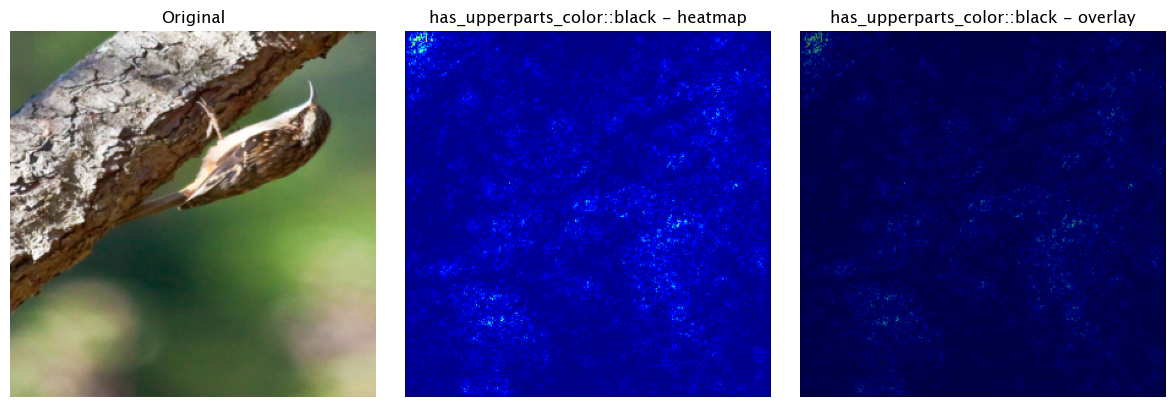

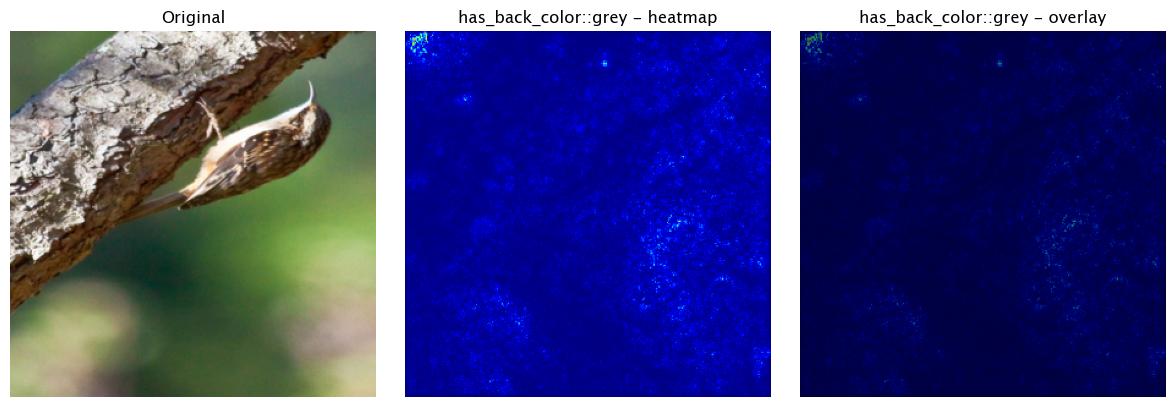

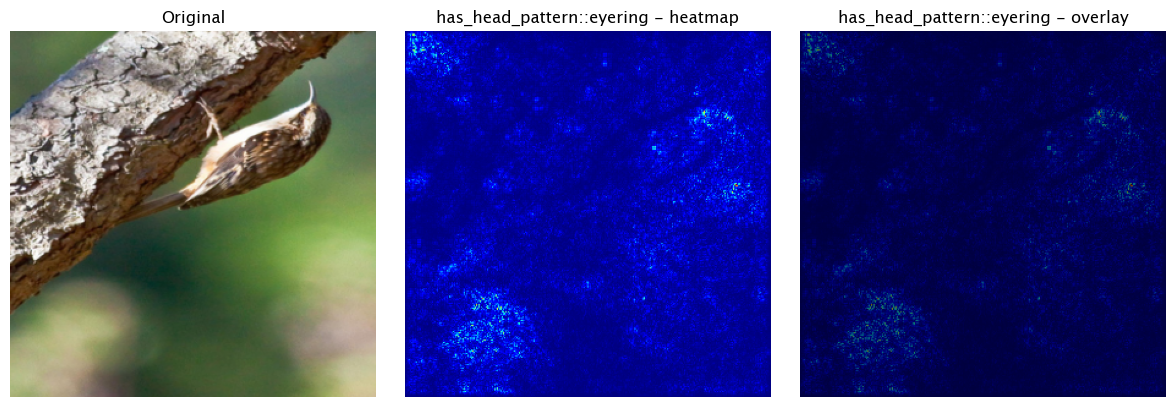

In [33]:
im_tensor, visible_attr, visible_attr_indx = random_sample()
image_np = np.array(im_tensor.detach().cpu()[0].permute(1, 2, 0))

for attr_name, attr_idx in zip(visible_attr, visible_attr_indx[:5]):
    # Use the single attribute index (attr_idx) instead of the entire list
    output_index = cub_attributes_list.index(attr_idx)
    wrapped_model = TensorOutputWrapper(model, out_index=output_index)

    expl = Saliency(wrapped_model)
    attributions = expl.attribute(im_tensor, target=0)

    channel_reduction = "absolute_mean"

    agg = aggregate_attributions(attributions, method=channel_reduction)  # (B,H,W)
    norm = normalize_map(agg)  # (B,H,W)
    # show first sample
    heat = norm[0]
    overlay = overlay_on_image(image_np, heat, alpha=0.5)
    fig, ax = plt.subplots(1,3, figsize=(12,4))
                
    # reverse this norm transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
    reversed_im = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    plot_im = (reversed_im - reversed_im.min()) / (reversed_im.max() - reversed_im.min())
 
    ax[0].imshow(plot_im)

    ax[0].set_title("Original")
    ax[1].imshow(heat, cmap='jet')
    ax[1].set_title(f"{attr_name} - heatmap")

    ax[2].imshow(overlay)
    ax[2].set_title(f"{attr_name} - overlay")  # Fixed: was ax[1]
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:

im_tensor, visible_attr, visible_attr_indx = random_sample()
image_np = np.array(im_tensor.detach().cpu()[0].permute(1, 2, 0))

for attr_name, attr_idx in zip(visible_attr, visible_attr_indx[:5]):
    # Use the single attribute index (attr_idx) instead of the entire list
    output_index = cub_attributes_list.index(attr_idx)
    wrapped_model = TensorOutputWrapper(model, out_index=output_index)

    # Replace Saliency with IntegratedGradients
    ig = IntegratedGradients(wrapped_model)
    
    # Compute attributions with Integrated Gradients
    # n_steps controls the approximation quality (default=50, higher is more accurate)
    attributions = ig.attribute(im_tensor, target=0, n_steps=50)

    channel_reduction = "absolute_mean"

    agg = aggregate_attributions(attributions, method=channel_reduction)  # (B,H,W)
    norm = normalize_map(agg)  # (B,H,W)
    # show first sample
    heat = norm[0]
    overlay = overlay_on_image(image_np, heat, alpha=0.5)
    fig, ax = plt.subplots(1,3, figsize=(12,4))
                
    # reverse this norm transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
    reversed_im = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    plot_im = (reversed_im - reversed_im.min()) / (reversed_im.max() - reversed_im.min())
 
    ax[0].imshow(plot_im)

    ax[0].set_title("Original")
    ax[1].imshow(heat, cmap='jet')
    ax[1].set_title(f"{attr_name} - heatmap (IG)")

    ax[2].imshow(overlay)
    ax[2].set_title(f"{attr_name} - overlay (IG)")
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

/var/folders/0s/djcnggfx34j59ddzgqd699z80000gn/T/ipykernel_2044/791498550.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_np = np.array(im_tensor.detach().cpu()[0].permute(1, 2, 0))
